# Midterm Exam (part 3) - Computational Physics I

### Deadline: Friday 25 October 2024 (by 17h00)
### Name: JOSUE MANTILLA

## Part 3. (12 points) Data analysis and visualisation (Orszag-Tang MHD vortex)

The **Orszag-Tang vortex** system describes a doubly periodic ideal gas configuration leading to 2D supersonic magnetohydrodynamical (MHD) turbulence. Although an analytical solution is not known, its simple and reproducible set of initial conditions has made it very appealing for the comparison of MHD numerical solvers. The computational domain is a **periodic box** with dimensions: $[0,2\pi]^2$, and the gas has an adiabatic index $\gamma=\frac{5}{3}$.

In code units, the initial conditions are given by:

$
\vec{v}_{code} = \left(-\sin y,\, \sin x\right) \,,\qquad
\vec{B}_{code} = \left(-\sin y,\, \sin 2x\right) \,,\qquad
\rho_{code} = 25/9\,,\qquad
p_{code}    = 5/3,
$

and the numerical simulation produces $61$ VTK files stored in:

- the **Orszag-Tang-MHD** folder: 

https://github.com/wbandabarragan/physics-teaching-data/blob/main/2D-data/Orszag_Tang-MHD.zip

which also contains the following descriptor files:

- a **units.out** file that contains the CGS normalisation values.
- a **vtk.out** file whose second column contains the times in code units.
- a **grid.out** file that contains information on the grid structure.

You can use VisIt to inspect the data. The written fields are: 

- density (rho)
- thermal pressure (prs)
- velocity_x (vx1)
- velocity_y (vx2)
- magnetic_field_x (Bx1)
- magnetic_field_y (Bx2)

**Reference paper:**
https://arxiv.org/pdf/1001.2832.pdf

"High-order conservative finite difference GLM-MHD schemes for cell-centered MHD", Mignone, Tzeferacos & Bodo, JCP (2010) 229, 5896.

### Tasks:

Within a single python notebook, carry out the following tasks:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from skimage.transform import rescale
import os
import glob 
from IPython import display
from PIL import Image 
import scienceplots

In [2]:
# Plot style
plt.style.use(['science', 'notebook', 'no-latex'])


(a) Create a python function that reads the **units.out** file, stores the normalisation values for length, velocity, and density, calculates the normalisation values for thermal pressure, magnetic field, and time, and returns them all into tuple objects.

**Note:**
As shown in class, the normalisation values for thermal pressure ($p_0=\rho_0\,v_0^2$), magnetic field ($B_0=\sqrt{4\,\pi\,\rho_0\,v_0^2}$), and time ($t_0=\frac{L_0}{v_0}$) can be derived from the length, velocity, and density values.

In [3]:
# Set the directory where the vtk files are stored
vtk_dir = './Orszag_Tang-MHD/'

In [4]:
# First, let's check the structure of the units.out file
df_units = pd.read_csv(vtk_dir + 'units.out')
print(df_units)

  variable  normalisation   units
0    rho_0   1.673000e-24  g/cm^3
1      v_0   1.000000e+05    cm/s
2      L_0   1.496000e+13      cm


In [5]:
def ReadUnits(filename):
    ''' 
    Read the units.out file and return the
    normalisation units for the simulation.

    Arguments:
            - filename (str) : the path to the units.out file

    Returns:
            - L_0 (float)   : the length normalisation in cm
            - v_0 (float)   : the velocity normalisation in cm/s
            - rho_0 (float) : the density normalisation in g/cm^3
            - p_0 (float)   : the thermal pressure normalisation in dyne/cm^2
            - B_0 (float)   : the magnetic field normalisation in G
            - t_0 (float)   : the time normalisation in s
    '''

    df_units = pd.read_csv(filename)

    # read the units and put them into a numpy array
    rho_0 = np.array(df_units.loc[df_units['variable'] == 'rho_0']['normalisation'])
    v_0   = np.array(df_units.loc[df_units['variable'] == 'v_0']['normalisation'])
    L_0   = np.array(df_units.loc[df_units['variable'] == 'L_0']['normalisation'])

    # compute  the missing units
    p_0 = rho_0 * v_0**2 # thermal pressure
    B_0 = v_0 * np.sqrt(4 * np.pi * rho_0)
    t_0 = L_0 / v_0

    return L_0, v_0, rho_0, p_0, B_0, t_0

In [6]:
# read the units
L_0, v_0, rho_0, p_0, B_0, t_0 = ReadUnits(vtk_dir + 'units.out')

In [7]:
# print the units
print("L_0 [cm]: ", L_0)
print("v_0 [cm/s]: ", v_0)
print("rho_0 [g/cm^3]: ", rho_0)
print("p_0 [barye]: ", p_0) #1 g⋅cm−1⋅s−2
print("B_0 [G]: ", B_0)
print("t_0 [s]: ", t_0)

L_0 [cm]:  [1.496e+13]
v_0 [cm/s]:  [100000.]
rho_0 [g/cm^3]:  [1.673e-24]
p_0 [barye]:  [1.673e-14]
B_0 [G]:  [4.58514319e-07]
t_0 [s]:  [1.496e+08]


(b) Create a python function that reads the **vtk.out** file, reads the second column, and returns the times in CGS units using $t_0$ from point (a).

In [8]:
def TimeData(filename):
    ''' 
    Function to read the time data from the vtk.out file 
    and return the normalised time data in cgs units.

    Arguments:
            - filename (str) : the path to the vtk.out file
    
    Returns:
            - time_cgs (np.array) : the normalised time data in cgs units
    '''
    
    # Read the data from the file
    df = pd.read_csv(filename, sep= r'\s+', header=None)
    
    # Extract the time data
    time_data = df.iloc[:, 1]

    # Normalise the time data
    time_cgs = time_data * t_0

    return time_cgs

In [9]:
# Get the time data
time_cgs = TimeData(vtk_dir + 'vtk.out')

(c) Create a python function that reads a VTK data file, normalises the data fields to CGS units using the values from points (a) and (b), and returns them jointly with the mesh and time information as tuple objects.

In [10]:
# First, let's check the structure of the vtk files
# Get the data into a mesh
mesh = pv.read(vtk_dir + 'data.0030.vtk')

print(mesh)
print(mesh.array_names)

RectilinearGrid (0x7b3a041cbb20)
  N Cells:      65536
  N Points:     66049
  X Bounds:     0.000e+00, 6.283e+00
  Y Bounds:     0.000e+00, 6.283e+00
  Z Bounds:     0.000e+00, 0.000e+00
  Dimensions:   257, 257, 1
  N Arrays:     6
['rho', 'vx1', 'vx2', 'Bx1', 'Bx2', 'prs']


In [11]:
# Now, let's write a function that reads the vtk files
# and returns the stored data

def ReadVTKData(filename):
    '''
    Read the vtk file, extract the data and 
    return reshaped 2D arrays of the data 
    in cgs units.

    Arguments:
            - filename (str) : the path to the vtk file

    Returns:
            - rho_cgs_2D (np.array) : the density data in g/cm^3
            - vx1_cgs_2D (np.array) : the x-velocity data in cm/s
            - vx2_cgs_2D (np.array) : the y-velocity data in cm/s
            - Bx1_cgs_2D (np.array) : the x-magnetic field data in G
            - Bx2_cgs_2D (np.array) : the y-magnetic field data in G
            - prs_cgs_2D (np.array) : the thermal pressure data in dyne/cm^2
    '''
    # Open the mesh
    mesh_data = pv.read(filename)

    # Get the data columns
    rho = pv.get_array(mesh_data, "rho", preference = 'cell')
    vx1 = pv.get_array(mesh_data, "vx1", preference = 'cell')
    vx2 = pv.get_array(mesh_data, "vx2", preference = 'cell')
    Bx1 = pv.get_array(mesh_data, "Bx1", preference = 'cell')
    Bx2 = pv.get_array(mesh_data, "Bx2", preference = 'cell')
    prs = pv.get_array(mesh_data, "prs", preference = 'cell')

    # Normalise the data and reshape the arrays to a 2D mesh
    rho_cgs_2D = np.array(rho.reshape(mesh_data.dimensions[0] - 1, mesh_data.dimensions[1] - 1) * rho_0)
    vx1_cgs_2D = np.array(vx1.reshape(mesh_data.dimensions[0] - 1, mesh_data.dimensions[1] - 1) * v_0)
    vx2_cgs_2D = np.array(vx2.reshape(mesh_data.dimensions[0] - 1, mesh_data.dimensions[1] - 1) * v_0)
    Bx1_cgs_2D = np.array(Bx1.reshape(mesh_data.dimensions[0] - 1, mesh_data.dimensions[1] - 1) * B_0)
    Bx2_cgs_2D = np.array(Bx2.reshape(mesh_data.dimensions[0] - 1, mesh_data.dimensions[1] - 1) * B_0)
    prs_cgs_2D = np.array(prs.reshape(mesh_data.dimensions[0] - 1, mesh_data.dimensions[1] - 1) * p_0)

    return rho_cgs_2D, vx1_cgs_2D, vx2_cgs_2D, Bx1_cgs_2D, Bx2_cgs_2D, prs_cgs_2D

(dx2) Call all the above functions for VTK file # 30 of each simulation, and make the following maps using the correct mesh coordinates, dimensions and time, all in in CGS units:

- A figure showing the gas density, $\rho$.

- A figure showing the gas sound speed, $c_s=\sqrt{\gamma\frac{p}{\rho}}$.

- A figure showing showing the kinetic energy density, $E_k = \frac{1}{2}\rho\,v^2$ with $v=\sqrt{v_x^2+v_y^2}$.

- A figure showing the magnetic vector field, $\vec{B}= \vec{B}_x + \vec{B}_y$.

**Notes:** Choose different perceptually-uniform colour schemes for each of the above quantities, and fix the colour bar limits. Add the correct time stamp in CGS units to each map. Since these are high-resolution models, one way to improve the visualisation of 2D vector fields is to interpolate them into a coarser grid.

In [13]:
# Call the function for the #30 vtk file
vtkfile = 'data.0030.vtk'

# Get the data
rho_cgs_2D, vx1_cgs_2D, vx2_cgs_2D, Bx1_cgs_2D, Bx2_cgs_2D, prs_cgs_2D = ReadVTKData(vtk_dir + vtkfile)

In [14]:
# Compute the quantities of interest
c_s = np.sqrt(prs_cgs_2D / rho_cgs_2D) # gas sound speed
E_k = 0.5 * rho_cgs_2D * (vx1_cgs_2D**2 + vx2_cgs_2D**2) # kinetic energy density [erg/cm^3] erg = g*cm^2/s^2

# Create the normalised meshgrid 
X = np.linspace(mesh.bounds[0], mesh.bounds[1], (mesh.dimensions[0] - 1)) * L_0
Y = np.linspace(mesh.bounds[2], mesh.bounds[3], (mesh.dimensions[1] - 1)) * L_0 

# Generate a meshgrid
X_2D, Y_2D = np.meshgrid(X, Y)

All the units are according to the CGS system: https://en.wikipedia.org/wiki/Centimetre%E2%80%93gram%E2%80%93second_system_of_units

In [15]:
# Define a function to rescale any vector field
def RescaleVectorField(x1, x2, n):
    """
    Function to resize a vector field.

    Arguments:
            - x1 (np.array) : the x-component of the vector field
            - x2 (np.array) : the y-component of the vector field
            - n (int)       : the scaling factor

    Returns:
            - x1_res (np.array) : the resized x-component of the vector field
            - x2_res (np.array) : the resized y-component of the vector field
            - mag_x_res (np.array) : the resized magnitude of the vector field
    """
    # Rescale the components
    x1_res = rescale(x1, n)
    x2_res = rescale(x2, n)
    
    mag_x = np.sqrt(x1**2 + x2**2)
    
    # Rescale the magnitude
    mag_x_res = rescale(mag_x, n)
    
    return x1_res, x2_res, mag_x_res

In [16]:
# Rescale the meshgrid and the magnetic field
X_2D_res, Y_2D_res,_ = RescaleVectorField(X_2D, Y_2D, 0.10)
Bx1_cgs_2D_res, Bx2_cgs_2D_res, B_mag_res = RescaleVectorField(Bx1_cgs_2D, Bx2_cgs_2D, 0.10)

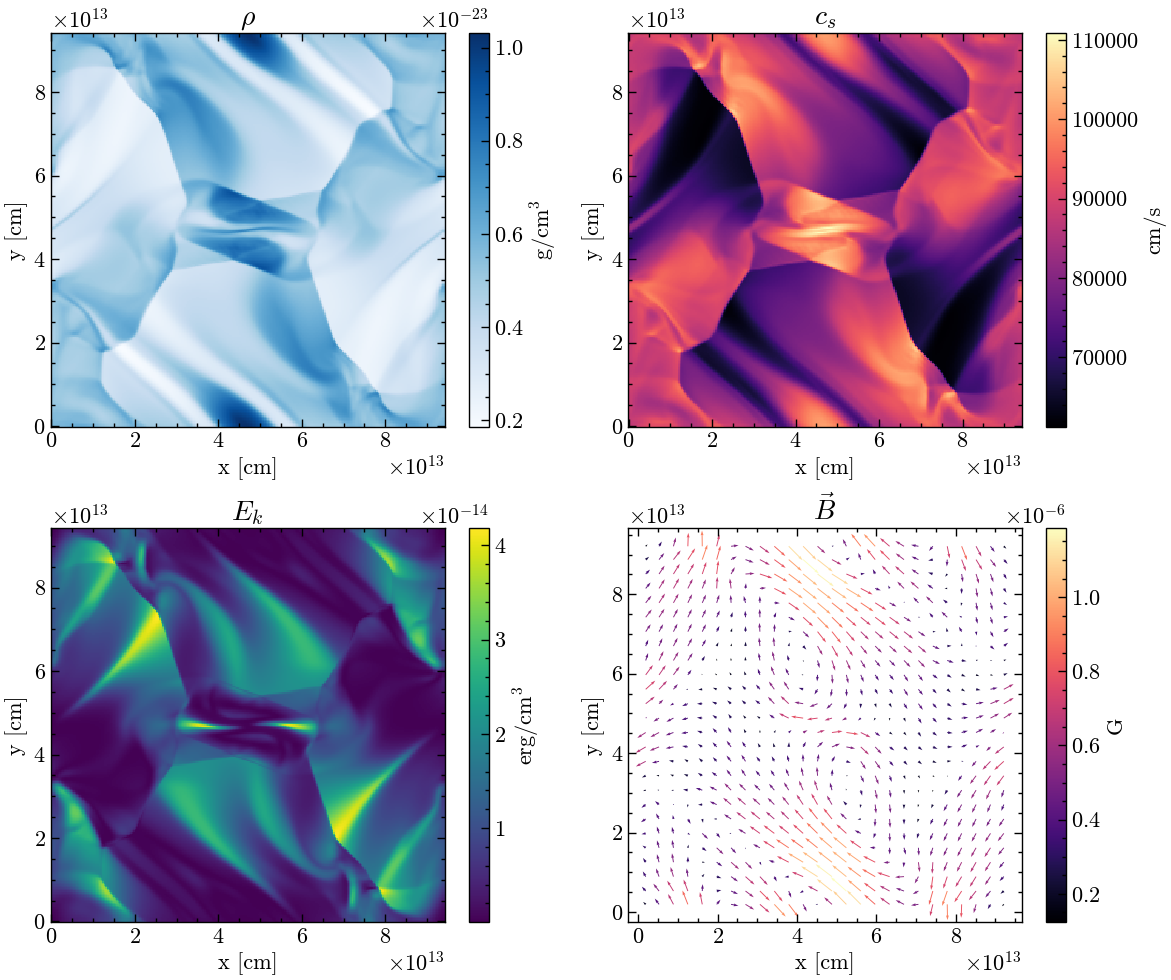

In [17]:
# Plot the data 
fig, ax = plt.subplots(2, 2, figsize = (12, 10))

# Density map
z1 = ax[0, 0].pcolor(X_2D, Y_2D, rho_cgs_2D, cmap = "Blues")
ax[0, 0].set_title(r"$\rho$", fontsize = 20)
ax[0, 0].set_xlabel("x [cm]")
ax[0, 0].set_ylabel("y [cm]")
cl1 = plt.colorbar(z1)
cl1.set_label(r"g/cm$^3$")

# Sound speed map
z2 = ax[0, 1].pcolor(X_2D, Y_2D, c_s, cmap = "magma")
ax[0, 1].set_title(r"$c_s$", fontsize = 20)
ax[0, 1].set_xlabel("x [cm]")
ax[0, 1].set_ylabel("y [cm]")
cl2 = plt.colorbar(z2)
cl2.set_label(r"cm/s")

# Kinetic energy density map
z3 = ax[1, 0].pcolor(X_2D, Y_2D, E_k, cmap = "viridis")
ax[1, 0].set_title(r"$E_k$", fontsize = 20)
ax[1, 0].set_xlabel("x [cm]")
ax[1, 0].set_ylabel("y [cm]")
cl3 = plt.colorbar(z3)
cl3.set_label(r"erg/cm$^3$")

# Magnetic field map
z4 = ax[1, 1].quiver(X_2D_res, Y_2D_res, Bx1_cgs_2D_res, Bx2_cgs_2D_res, B_mag_res, cmap = "magma")
ax[1, 1].set_title(r"$\vec{B}$", fontsize = 20)
ax[1, 1].set_xlabel("x [cm]")
ax[1, 1].set_ylabel("y [cm]")
cl4 = plt.colorbar(z4)
cl4.set_label(r"G")

fig.tight_layout()
plt.show()
plt.close()

(e) Create a set of Python functions that loops over all the VTK simulation files and returns maps of the density field $\rho$, the kinetic energy density $E_k$, and also histograms of the density field in CGS units for all times, into a folder called "output_data".

In [19]:
# Create the directory to store the images
if os.path.isdir("./midterm_output_data"):
    print("Directory already exists.")
else: 
    print("Directory has been created.")
    os.mkdir("./midterm_output_data")

maps_directory = "./midterm_output_data/"

Directory has been created.


In [20]:
# Let's write a function to plot each map in a separate figure
def DensityMapPlot(rho, time, n):
    '''
    Function to plot the density map. 

    Arguments:
            - rho (np.array) : the density data in g/cm^3
            - time (float)   : the time in cgs units
            - n (int)        : the number of the vtk file

    Returns:
            - save the map as a .png file
    '''
    fig, ax = plt.subplots(1, 1, figsize = (8, 6))
    z = ax.pcolor(X_2D, Y_2D, rho, cmap = "Blues", vmin = 0, vmax = 1e-23)
    ax.set_title(r"$\rho\,[t = " + f"{time:.2e}" + "\\,s" + "]$", fontsize = 20)
    ax.set_xlabel("x [cm]")
    ax.set_ylabel("y [cm]")
    cl = plt.colorbar(z)
    cl.set_label(r"g/cm$^3$")

    #plt.show()
    plt.savefig(maps_directory + "density_map_{:03d}.png".format(n))
    plt.close()


def KineticEnergyMapPlot(E_k, time, n):
    '''
    Function to plot the kinetic energy density map 

    Arguments:
            - E_k (np.array) : the kinetic energy density data in erg/cm^3
            - time (float)   : the time in cgs units
            - n (int)        : the number of the vtk file

    Returns:
            - save the map as a .png file
    '''
    fig, ax = plt.subplots(1, 1, figsize = (8, 6))
    z = ax.pcolor(X_2D, Y_2D, E_k, cmap = "viridis", vmin = 0, vmax = 5e-14)
    ax.set_title(r"$E_k\,[t = " + f"{time:.2e}" + "\\,s" + "] $", fontsize = 20)
    ax.set_xlabel("x [cm]")
    ax.set_ylabel("y [cm]")
    cl = plt.colorbar(z)
    cl.set_label(r"erg/cm$^3$")

    #plt.show()
    plt.savefig(maps_directory + "kinetic_energy_map_{:03d}.png".format(n))
    plt.close()

def DensityHist(rho, time, n):
    '''
    Function to plot the density histogram

    Arguments:
            - rho (np.array) : the density data in g/cm^3
            - time (float)   : the time in cgs units
            - n (int)        : the number of the vtk file

    Returns:
            - save the histogram as a .png file
    '''
    fig, ax = plt.subplots(1, 1, figsize = (8, 6))
    ax.hist(rho.flatten(), bins = 50, color = "blue", alpha = 0.7)
    ax.set_title(r"$\rho\,[t = " + f"{time:.2e}" + "\\,s" + "]$", fontsize = 20)
    ax.set_xlabel(r"$\rho$ [g/cm$^3$]")
    ax.set_ylabel("Frequency")  

    #plt.show()
    plt.savefig(maps_directory + "density_histogram_{:03d}.png".format(n))
    plt.close()

In [21]:
# Loop over the vtk files and plot the maps
for i in range(0,len(time_cgs)):
    
    # Define filename 
    file = vtk_dir + "data.0{:03d}.vtk".format(i) 

    # Get the data (2D)
    rho, vx1, vx2, _, _, _ = ReadVTKData(file)

    E_k = 0.5 * rho * (vx1**2 + vx2**2) # kinetic energy density [erg/cm^3] erg = g*cm^2/s^2

    # Call the functions to plot the maps
    DensityMapPlot(rho, time_cgs[i], i)
    KineticEnergyMapPlot(E_k, time_cgs[i], i)
    DensityHist(rho, time_cgs[i], i)


(f) Briefly describe: what happens with the density field as time progresses? Does the density field follow any statistical distribution at late times?

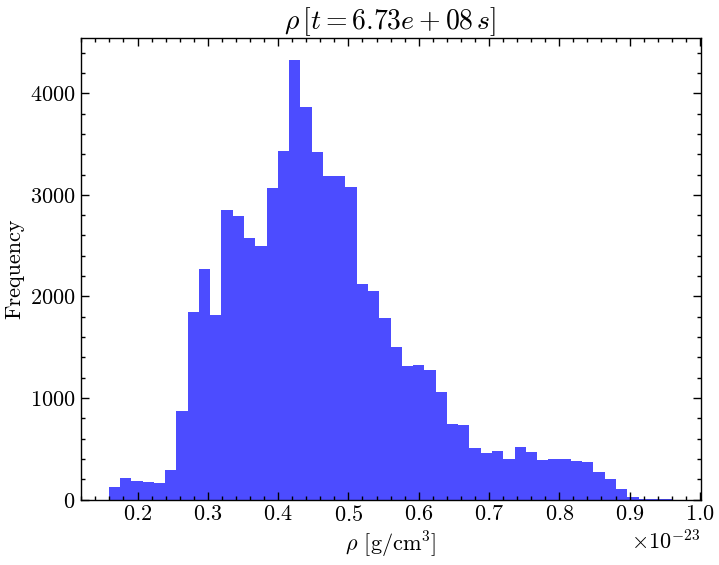

In [22]:
# Import the histogram of the vtk #45 file
img = Image.open(maps_directory + "density_histogram_045.png")
display.display(img)

At the beginning of the simulation, the density field is uniform, but as time progresses, the density field becomes turbulent and develops regions of high and low density. The density field follows a log-normal distribution at late times.

(gx2) Create a set of Python functions that loops over all the VTK simulation files, computes the following quantities in CGS units for each time:

- the average gas temperature, $\overline T$, (**Hint:** the temperature in each grid cell can be calculated using the equation of state for ideal gases, i.e., $p=\frac{\rho k_B\,T}{\mu m_u}$, where $k_B$ is the Boltzmann constant, $m_u$ is the atomic mass unit, and $\mu=0.6$ is the mean particle mass in the gas.)

- the average kinetic energy density, $\overline E_k$, where $E_k = \frac{1}{2}\rho\,v^2$.

- the average magnetic energy density, $\overline E_m$, where $E_m = \frac{1}{2}\frac{B^2}{\,\mu_0}$, where $\mu_0\equiv$ magnetic permeability of free space.

and returns:

- a CSV file with 4 columns, time on the first column, and the above quantities in the next ones. The CSV file should be named "stats.csv" saved into the folder called "output_data".

Some physical constants in CGS units: https://www.physics.rutgers.edu/~gawiser/342/constants.html

In [23]:
# Compute the average Temperature
def AvgTemperature(prs, rho):
    '''
    Function to compute the average temperature 

    Arguments:
            - prs (np.array) : the thermal pressure data in dyne/cm^2
            - rho (np.array) : the density data in g/cm^3

    Returns:
            - T_avg (float) : the average temperature in K
    '''
    # Constants
    k_B = 1.38e-16 # erg/K
    m_u = 1.67e-24 # g
    mu = 0.6 # mean molecular weight

    # Compute the temperature
    T = (prs / rho) * (mu * m_u) / k_B
    # Compute the average temperature
    T_avg = np.mean(T)

    return T_avg

def AvgKineticEnergy(rho, vx1, vx2):
    '''
    Function to compute the average kinetic energy

    Arguments:
            - rho (np.array) : the density data in g/cm^3
            - vx1 (np.array) : the x-velocity data in cm/s
            - vx2 (np.array) : the y-velocity data in cm/s

    Returns:
            - E_k_avg (float) : the average kinetic energy in erg/cm^3
    '''
    # Compute the kinetic energy
    E_k = 0.5 * rho * (vx1**2 + vx2**2)
    # Compute the average kinetic energy
    E_k_avg = np.mean(E_k)

    return E_k_avg

def AvgMagneticEnergy(Bx1, Bx2):
    '''
    Function to compute the average magnetic energy

    Arguments:
            - Bx1 (np.array) : the x-magnetic field data in G
            - Bx2 (np.array) : the y-magnetic field data in G

    Returns:
            - E_m_avg (float) : the average magnetic energy in erg/cm^3
    '''
    # magnetic permeability in cgs units
    mu_0 = 1 # dimensionless

    # Compute the magnetic energy
    E_m = 0.5 * (Bx1**2 + Bx2**2)/ mu_0
    # Compute the average magnetic energy
    E_m_avg = np.mean(E_m)

    return E_m_avg

In [24]:
# Define empty lists to store the average values
avg_temp = []
avg_kin_energy = []
avg_mag_energy = []

In [25]:
# Iterate over all the vtk files
for i in range(0, len(time_cgs)):
    
    # Define filename 
    file = vtk_dir + "data.0{:03d}.vtk".format(i) 

    # Get the data (2D)
    rho_2, vx1_2, vx2_2, Bx1_2, Bx2_2, prs_2 = ReadVTKData(file)

    # Compute the average temperature
    T_avg = AvgTemperature(prs_2, rho_2)
    avg_temp.append(T_avg)

    # Compute the average kinetic energy
    E_k_avg = AvgKineticEnergy(rho_2, vx1_2, vx2_2)
    avg_kin_energy.append(E_k_avg)

    # Compute the average magnetic energy
    E_m_avg = AvgMagneticEnergy(Bx1_2, Bx2_2)
    avg_mag_energy.append(E_m_avg)

In [26]:
# Save the data into a pandas dataframe and write it to a csv file
avg_data = {"Time [s]": time_cgs, "Avg Temperature [K]": np.array(avg_temp),
            "Avg Kinetic Energy [erg/cm^3]": np.array(avg_kin_energy),
            "Avg Magnetic Energy [erg/cm^3]": np.array(avg_mag_energy)}

df_avg = pd.DataFrame(avg_data)

#print(df_avg)
# Write the data to a csv file
df_avg.to_csv(maps_directory + "stats.csv", sep = ",", index = False)

(h) Create a Python function that reads in the CSV file created in (g) and returns (i.e. shows or saves) high-quality labeled figures of each of the above-computed quantities versus time, into the folder called "output_data". 

In [27]:
def ReadAvgQuantities(filename):
    '''
    Function to read the average data from the csv file

    Arguments:
            - filename (str) : the path to the csv file

    Returns:
            - time (np.array) : the time data in cgs units
            - avg_temp (np.array) : the average temperature data in K
            - avg_kin_energy (np.array) : the average kinetic energy data in erg/cm^3
            - avg_mag_energy (np.array) : the average magnetic energy data in erg/cm^3
    '''
    df_avg = pd.read_csv(filename, sep = ",")

    time = np.array(df_avg["Time [s]"])
    avg_temp = np.array(df_avg["Avg Temperature [K]"])
    avg_kin_energy = np.array(df_avg["Avg Kinetic Energy [erg/cm^3]"])
    avg_mag_energy = np.array(df_avg["Avg Magnetic Energy [erg/cm^3]"])

    return time, avg_temp, avg_kin_energy, avg_mag_energy

In [28]:
# Call the function to read the average data
time, avg_temp, avg_kin_energy, avg_mag_energy = ReadAvgQuantities(maps_directory + "stats.csv")

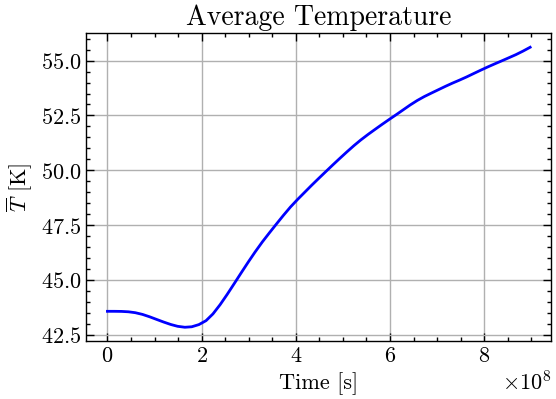

In [31]:
# Plot the average temperature vs time
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(time, avg_temp, color = "blue")
ax.set(xlabel = "Time [s]", ylabel = r"$\overline{T}$ [K]")
ax.set_title("Average Temperature", fontsize = 20)
plt.grid(True)
plt.savefig(maps_directory + "avg_temp_vs_time.png")
plt.show()
plt.close()

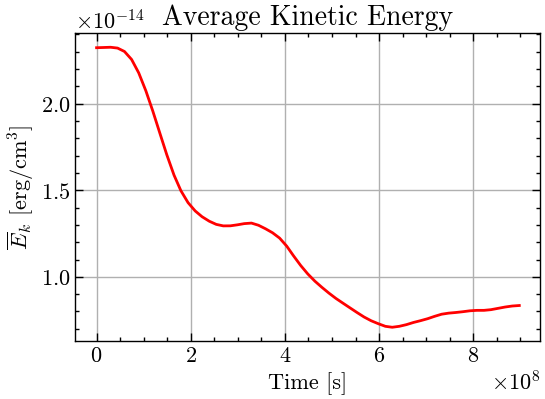

In [32]:
# Plot the average kinetic energy vs time
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(time, avg_kin_energy, color = "red")
ax.set(xlabel = "Time [s]", ylabel = r"$\overline{E}_k$ [erg/cm$^3$]")
ax.set_title("Average Kinetic Energy", fontsize = 20)
plt.grid(True)
plt.savefig(maps_directory + "avg_kinetic_energy.png")
plt.show()

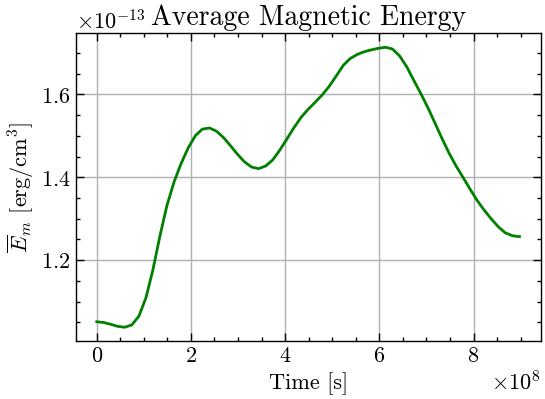

In [34]:
# Plot the average magnetic energy vs time
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(time, avg_mag_energy, color = "green")
ax.set(xlabel = "Time [s]", ylabel = r"$\overline{E}_m$ [erg/cm$^3$]")
ax.set_title("Average Magnetic Energy", fontsize = 20) 
plt.grid(True)
plt.savefig(maps_directory + "avg_magnetic_energy.png")
plt.show()

(i) Briefly describe: Does the flow reach steady state? Which energy density is dominant?

Although the average gas temperature has an increasing trend, it is likely to reach a steady state at late times. On the other hand, after time $t\approx$ 6E+8, the average kinetic energy seems to reach a steady state, so does the average magnetic energy density for $t\geq$ 8E+8. Throughout the simulation, the average magnetic energy density is dominant.

(j) Create a Python function that returns movies showing the time evolution of the kinetic energy density maps computed in (d) and their average values calculated in (g). The movies should be saved into the folder called "output_data". 

In [35]:
# Create a function to plot the kinetic energy density map and its corresponding average value in 
# a two-panel figure
def AnimationFrames(Ek_density, n):
    '''
    Function to plot the kinetic energy density map and its corresponding average value
    at a given time step.

    Arguments:
            - Ek_density (np.array) : the kinetic energy density data in erg/cm^3
            - n (int)               : the time step

    Returns:
            - save the figure as a .png file
    '''

    avg_Ek = avg_kin_energy 

    fig, ax = plt.subplots(1, 2, figsize = (12, 5))

    # Plot the density map
    z1 = ax[0].pcolor(X_2D, Y_2D, Ek_density, cmap = "magma", vmin = 0, vmax = 5e-14)
    ax[0].set_title(r"$E_k \,[t = " + f"{time[n]:.2e}" + "\\,s" + "]$", fontsize = 20)
    ax[0].set_xlabel("x [cm]")
    ax[0].set_ylabel("y [cm]")
    cl1 = plt.colorbar(z1)
    cl1.set_label(r"erg/cm$^3$")

    # Plot the average kinetic energy
    ax[1].plot(time[:n], avg_Ek[:n], color = "red")
    ax[1].set_title(r"$\overline{E}_k \,[t = " + f"{time[n]:.2e}" + "\\,s" + "]$", fontsize = 20)
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylabel(r"$\overline{E}_k$ [erg/cm$^3$]")
    ax[1].set_xlim(0, time[-1])
    ax[1].set_ylim(0.5e-14, 2.5e-14)

    fig.tight_layout()

    # Save the figure
    plt.savefig(maps_directory + "Ek_animation_{:03d}.png".format(n))
    plt.close()
    #plt.show()

In [36]:
for i in range(0, len(time)):
    
    # Define the vtk file name
    vtkfiles = vtk_dir + "data.0{:03d}.vtk".format(i)

    # Get the data
    rho_3, vx1_3, vx2_3, _, _, _ = ReadVTKData(vtkfiles)

    # Compute the kinetic energy density
    E_k_3 = 0.5 * rho_3 * (vx1_3**2 + vx2_3**2)

    # Call the function to plot the animation frames
    AnimationFrames(E_k_3, i)

In [37]:
# Now, let's use the images to create an animation
images_input = "./midterm_output_data/Ek_animation_*.png"
imgif_output = "./midterm_output_data/kinetic_energy_animation.gif"

# Collect the images 
imgs = (Image.open(f) for f in sorted(glob.glob(images_input)))

img = next(imgs)

img.save(fp = imgif_output, format = "GIF", append_images = imgs,\
         save_all = True, duration = 100, loop = 0)

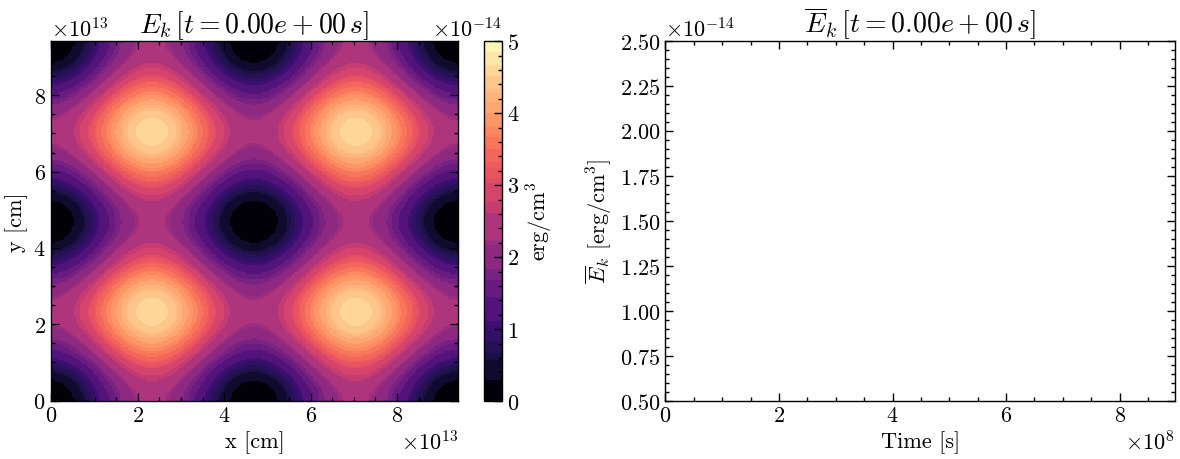

In [38]:
# Display the animation
display.Image(filename = imgif_output)